In [ ]:
import datetime
import random
import time

import numpy
import pandas
import scipy
import matplotlib.pyplot as plt
import IPython.display as disp

class Progress:
    """Wrapper for IPython.display.ProgressBar with improved performance"""

    def __init__(self, total):
        self.bar = disp.ProgressBar(total)
        self.progress = 0
        self.last = 0
    def inc(self):
        self.progress += 1
        if time.monotonic_ns() - self.last > 1e8:
            self.bar.progress = self.progress
            self.bar.update()
            self.last = time.monotonic_ns()
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_value, tb):
        self.bar.progress = self.progress
        self.bar.update()
        return False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!test -d dataset || unzip /content/drive/Shareddrives/'STAT4609 Netflix'/dataset.zip -d dataset

Archive:  /content/drive/Shareddrives/STAT4609 Netflix/dataset.zip
  inflating: dataset/README          
  inflating: dataset/combined_data_1.txt  
  inflating: dataset/combined_data_2.txt  
  inflating: dataset/combined_data_3.txt  
  inflating: dataset/combined_data_4.txt  

In [ ]:
class Counter:
    """Assigns an ID mapping to non-contiguous values"""

    def __init__(self):
        self.cache = {}
    def resolve(self, value, max):
        if value in self.cache:
            return self.cache[value]
        id = len(self.cache)
        if id >= max:
            return None
        self.cache[value] = id
        return id
    def size(self):
        return len(self.cache)

user_counter = Counter()
movie_counter = Counter()

def read_ratings_file(data, path, row, progress):
    with open(path) as fh:
        for line in fh:
            line = line.rstrip("\r\n")
            if line.endswith(":"):
                movie_id = int(line[:-1])
                movie_id = movie_counter.resolve(movie_id, 10000)
                progress.inc()
                if movie_id is None:
                    break
            elif "," in line:
                user, rating, date = line.split(",")
                user = int(user)
                rating = int(rating)
                user_id = user_counter.resolve(user, 1000)
                if user_id is None:
                    continue
                y, m, d = date.split("-")
                date = datetime.date(int(y), int(m), int(d))
                data[row] = [movie_id, int(user_id), int(rating), y, date.timetuple().tm_yday, date.weekday()]
                row += 1
    return row

def read_ratings():
    # data = numpy.zeros([100498277, 6])
    data = numpy.zeros([1000000, 6])
    row = 0
    with Progress(10000) as progress:
        row = read_ratings_file(data, "dataset/combined_data_1.txt", row, progress)
        row = read_ratings_file(data, "dataset/combined_data_2.txt", row, progress)
        row = read_ratings_file(data, "dataset/combined_data_3.txt", row, progress)
        row = read_ratings_file(data, "dataset/combined_data_4.txt", row, progress)
    return data[:row]

data = read_ratings()

[============================================================] 10002/10000

In [ ]:
movie_count = movie_counter.size()
user_count = user_counter.size()

def split_fill_ratings(data):
    output = numpy.empty((user_count, movie_count))
    output[:, :] = numpy.nan

    evaluation = []

    with Progress(data.shape[0]) as progress:
        for i in range(data.shape[0]):
            user = int(data[i, 1])
            movie = int(data[i, 0])
            rating = data[i, 2]

            if random.randrange(0, 100) < 20:
                evaluation.append((user, movie, rating))
            else:
                output[user, movie] = rating
            progress.inc()
    
    return output, evaluation

ratings, evaluation = split_fill_ratings(data)

[============================================================] 508093/508093

In [ ]:
class SimpleSvd:
    def __init__(self, learning_rate, regularization, rank, epochs):
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.rank = rank
        self.epochs = epochs

    def fit(self, ratings):
        mu = numpy.nanmean(ratings)

        bias_users = numpy.random.normal(scale=0.5, size=(user_count,))
        bias_movies = numpy.random.normal(scale=0.5, size=(movie_count,))

        latent_users = numpy.random.normal(scale=0.5, size=(user_count, self.rank))
        latent_movies = numpy.random.normal(scale=0.5, size=(movie_count, self.rank))

        filled_user, filled_movie = numpy.where(numpy.logical_not(numpy.isnan(ratings)))
        filled_count = filled_user.shape[0]

        history = []
        with Progress(self.epochs * filled_count) as progress:
            for epoch in range(self.epochs):
                mse = 0
                for user, movie in zip(filled_user, filled_movie):
                    est = mu + bias_users[user] + bias_movies[movie] + numpy.dot(latent_users[user, :], latent_movies[movie, :])
                    err = ratings[user, movie] - est

                    bias_users[user] += self.learning_rate * (err - self.regularization * bias_users[user])
                    bias_movies[movie] += self.learning_rate * (err - self.regularization * bias_movies[movie])
                    latent_users[user, :] += self.learning_rate * (err * latent_movies[movie, :] - self.regularization * latent_users[user, :])
                    latent_movies[movie, :] += self.learning_rate * (err * latent_users[user, :] - self.regularization * latent_movies[movie, :])

                    mse += err * err
                    progress.inc()

                history.append(numpy.sqrt(mse / filled_count))
                print(f"Epoch {epoch}, mse = {mse / filled_count}")
        
        plt.xlabel("Epochs")
        plt.ylabel("RMSE")
        plt.plot(numpy.arange(self.epochs), history)
        plt.show()

        self.mu = mu
        self.bias_users = bias_users
        self.bias_movies = bias_movies
        self.latent_users = latent_users
        self.latent_movies = latent_movies

        return self

    def predict(self, user, movie):
        return self.mu + self.bias_users[user] + self.bias_movies[movie] + numpy.sum(self.latent_users[user, :] * self.latent_movies[movie, :])

    def evaluate(self, evaluation):
        se = 0
        for user, movie, rating in evaluation:
            err = self.predict(user, movie) - rating
            se += err ** 2
        print("Test RMSE: {}".format(numpy.sqrt(se / len(evaluation))))

[==========================================                  ] 11383003/16243360

Epoch 0, mse = 3.9043609068801883
Epoch 1, mse = 1.605133978502547
Epoch 2, mse = 1.2041281054321304
Epoch 3, mse = 1.0337332437459033
Epoch 4, mse = 0.938846711747596
Epoch 5, mse = 0.8771160149383905
Epoch 6, mse = 0.8324993409704966
Epoch 7, mse = 0.797724374416866
Epoch 8, mse = 0.7690929789106409
Epoch 9, mse = 0.7445652158475373
Epoch 10, mse = 0.7229410424521606
Epoch 11, mse = 0.7034736929169344
Epoch 12, mse = 0.6856739404540778
Epoch 13, mse = 0.6692059332813746
Epoch 14, mse = 0.6538294513975128
Epoch 15, mse = 0.6393666540917453
Epoch 16, mse = 0.6256821807740245
Epoch 17, mse = 0.6126707549613059
Epoch 18, mse = 0.6002491314846339
Epoch 19, mse = 0.5883506381360064
Epoch 20, mse = 0.5769213220436906
Epoch 21, mse = 0.5659171281187267
Epoch 22, mse = 0.5553017703610569
Epoch 23, mse = 0.5450450896831012
Epoch 24, mse = 0.5351217686056716
Epoch 25, mse = 0.5255103179585124
Epoch 26, mse = 0.5161922770996481
Epoch 27, mse = 0.5071515849217164


[============================================================] 16243360/16243360

Epoch 28, mse = 0.49837408856776916
Epoch 29, mse = 0.4898471630355375
Epoch 30, mse = 0.4815594192845801
Epoch 31, mse = 0.47350048196423794
Epoch 32, mse = 0.4656608209121556
Epoch 33, mse = 0.45803162332557845
Epoch 34, mse = 0.4506046960321689
Epoch 35, mse = 0.4433723895612563
Epoch 36, mse = 0.43632753770771265
Epoch 37, mse = 0.42946340795899945
Epoch 38, mse = 0.42277365951855206
Epoch 39, mse = 0.4162523067179357


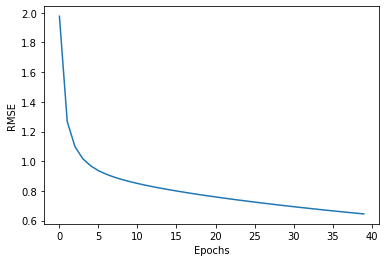

Test RMSE: 1.269245220809181


In [7]:
SimpleSvd(0.005, 0.0, 100, 40).fit(ratings).evaluate(evaluation)

[============================================================] 16243360/16243360

Epoch 0, mse = 3.8446319078107765
Epoch 1, mse = 1.5744625574230084
Epoch 2, mse = 1.1839809764780689
Epoch 3, mse = 1.018946986119016
Epoch 4, mse = 0.9275517462587688
Epoch 5, mse = 0.8684080841048136
Epoch 6, mse = 0.8258629468634361
Epoch 7, mse = 0.7928286625856
Epoch 8, mse = 0.7656985146308812
Epoch 9, mse = 0.7424754376410755
Epoch 10, mse = 0.7219771495573515
Epoch 11, mse = 0.7034634337681789
Epoch 12, mse = 0.6864484087314167
Epoch 13, mse = 0.670600378551891
Epoch 14, mse = 0.6556855754831292
Epoch 15, mse = 0.6415349917853739
Epoch 16, mse = 0.6280239361455204
Epoch 17, mse = 0.6150589272246492
Epoch 18, mse = 0.6025689988023109
Epoch 19, mse = 0.5904997559775165
Epoch 20, mse = 0.5788091998375587
Epoch 21, mse = 0.5674647179806963
Epoch 22, mse = 0.5564408609431164
Epoch 23, mse = 0.5457176604733359
Epoch 24, mse = 0.5352793312622263
Epoch 25, mse = 0.5251132528355665
Epoch 26, mse = 0.5152091639093856
Epoch 27, mse = 0.5055585242088354
Epoch 28, mse = 0.49615401278506993

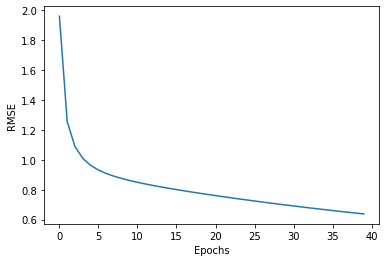

Test RMSE: 1.1562799703503093


In [8]:
SimpleSvd(0.005, 0.01, 100, 40).fit(ratings).evaluate(evaluation)

[============================================================] 16243360/16243360

Epoch 0, mse = 2.548336919038688
Epoch 1, mse = 1.3701500850085435
Epoch 2, mse = 1.1323169145085734
Epoch 3, mse = 1.0244793016000504
Epoch 4, mse = 0.9615675670826781
Epoch 5, mse = 0.9191219585549587
Epoch 6, mse = 0.887452895961696
Epoch 7, mse = 0.861994347360733
Epoch 8, mse = 0.840373126838278
Epoch 9, mse = 0.8212957023574128
Epoch 10, mse = 0.8040418660983044
Epoch 11, mse = 0.7881983328908231
Epoch 12, mse = 0.7735099826619973
Epoch 13, mse = 0.7598004825180562
Epoch 14, mse = 0.746934250225453
Epoch 15, mse = 0.7348000595971628
Epoch 16, mse = 0.7233041486893216
Epoch 17, mse = 0.7123668612577433
Epoch 18, mse = 0.7019204709253464
Epoch 19, mse = 0.6919074391632912
Epoch 20, mse = 0.6822789165411935
Epoch 21, mse = 0.672993446959472
Epoch 22, mse = 0.664015858941002
Epoch 23, mse = 0.6553163247719288
Epoch 24, mse = 0.6468695642749772
Epoch 25, mse = 0.6386541697053258
Epoch 26, mse = 0.6306520306340916
Epoch 27, mse = 0.6228478411713246
Epoch 28, mse = 0.6152286754433808
Ep

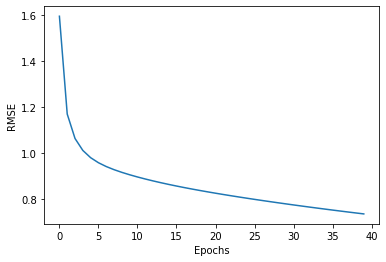

Test RMSE: 1.082470246953725


In [9]:
SimpleSvd(0.005, 0.0, 50, 40).fit(ratings).evaluate(evaluation)

[============================================================] 16243360/16243360

Epoch 0, mse = 1.5133697847359937
Epoch 1, mse = 1.1190776927951755
Epoch 2, mse = 1.028544174446055
Epoch 3, mse = 0.9841957663237556
Epoch 4, mse = 0.9572362282998783
Epoch 5, mse = 0.9387611792927263
Epoch 6, mse = 0.9250041997033859
Epoch 7, mse = 0.9140608644590068
Epoch 8, mse = 0.9048376087713766
Epoch 9, mse = 0.8966392469405806
Epoch 10, mse = 0.8889895634069707
Epoch 11, mse = 0.8815542626050301
Epoch 12, mse = 0.8741142426325307
Epoch 13, mse = 0.8665594027356822
Epoch 14, mse = 0.8588795920333822
Epoch 15, mse = 0.8511388934513844
Epoch 16, mse = 0.8434364529730016
Epoch 17, mse = 0.835869670012457
Epoch 18, mse = 0.8285127119356034
Epoch 19, mse = 0.821411321860089
Epoch 20, mse = 0.8145871397518303
Epoch 21, mse = 0.8080448069318583
Epoch 22, mse = 0.8017783311380153
Epoch 23, mse = 0.7957757135645941
Epoch 24, mse = 0.790021973607812
Epoch 25, mse = 0.7845010036535677
Epoch 26, mse = 0.7791966552536935
Epoch 27, mse = 0.7740933477137262
Epoch 28, mse = 0.7691763887590519

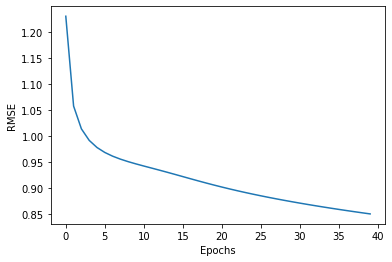

Test RMSE: 0.9547394211633511


In [10]:
SimpleSvd(0.005, 0.0, 10, 40).fit(ratings).evaluate(evaluation)

[============================================================] 16243360/16243360

Epoch 0, mse = 3.1488466800170585
Epoch 1, mse = 1.201590819289341
Epoch 2, mse = 0.9867355986848432
Epoch 3, mse = 0.8910159605922267
Epoch 4, mse = 0.8299930013995165
Epoch 5, mse = 0.7837216387697681
Epoch 6, mse = 0.7453928964504358
Epoch 7, mse = 0.712076517363863
Epoch 8, mse = 0.6822689054928215
Epoch 9, mse = 0.6551023516527872
Epoch 10, mse = 0.6300375908802892
Epoch 11, mse = 0.606720709740397
Epoch 12, mse = 0.5849074361441723
Epoch 13, mse = 0.5644202396117856
Epoch 14, mse = 0.5451233878906543
Epoch 15, mse = 0.526908378961378
Epoch 16, mse = 0.5096853853298637
Epoch 17, mse = 0.4933780936309501
Epoch 18, mse = 0.4779204133272928
Epoch 19, mse = 0.46325422070573313
Epoch 20, mse = 0.4493277133779904
Epoch 21, mse = 0.4360941670552033
Epoch 22, mse = 0.4235109879433732
Epoch 23, mse = 0.41153899637164104
Epoch 24, mse = 0.4001418935334077
Epoch 25, mse = 0.3892858703707824
Epoch 26, mse = 0.3789393228231734
Epoch 27, mse = 0.3690726431543428
Epoch 28, mse = 0.35965806303982

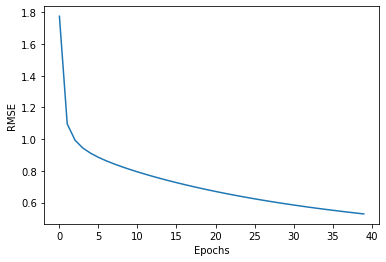

Test RMSE: 1.379377109828743


In [12]:
SimpleSvd(0.01, 0.0, 100, 40).fit(ratings).evaluate(evaluation)